# Exploring Joining and comparing tables with images

In [2]:
import random
import wandb

In [3]:
PROJECT_NAME = "stacking_tables"

In [4]:
def one_table():
    t = wandb.Table(columns=["col1", "col2"])
    for i in range(10):
        t.add_data(i, random.random())
    return t

one table, no issues on the workspace

In [5]:
def run_one_table():
    with wandb.init(project=PROJECT_NAME, job_type="simple"):
        wandb.log({"table_simple":one_table()})
        
run_one_table()

wandb: Currently logged in as: capecape. Use `wandb login --relogin` to force relogin


if we execute this multiple times, we can then see them concatenated (per row) on the workspace, no problem 

In [6]:
for _ in range(4):
    run_one_table()

## Multiple logs `run_one_table`

Ok, now what happens that if within the same run, we log a table with the same name, as one would do during training a model. Maybe logging samples per epoch or every X steps.

In [7]:
epochs = 5

with wandb.init(project=PROJECT_NAME, job_type="multi"):
    for e in range(epochs):
        wandb.log({"table_multi":one_table()})

## with Images

I am interested on Images on tables, so let's do that! Why? because when training generative image models, you want to see the samples during training. You can keep the prompt fixed and sample over time and see your model progress! (Remember avocado chair)

In [10]:
from pathlib import Path

from PIL import Image
import numpy as np

In [11]:
EPOCHS = 7

You will need 3 images of Pikachu to run this...

In [12]:
img_folder = Path("images/")
pikachu_images = list(img_folder.glob("pika*.png"))
pikachu_images

[PosixPath('images/pika1.png'),
 PosixPath('images/pika2.png'),
 PosixPath('images/pika3.png')]

In [27]:
def _scale_image(np_img, scale=1.0):
    scaled_img = scale * np_img
    return scaled_img.astype(np.uint8)

In [28]:
def sample_images(epoch):
    "Simulates model sampling at epoch"
    imgs = []
    for img_path in pikachu_images:
        pil_img = Image.open(img_path)
        np_img = np.array(pil_img)
        scaled_image = _scale_image(np_img, scale=epoch/EPOCHS)
        imgs.append(scaled_image)
    return imgs

In [29]:
def create_table(epoch):
    "Create a wandb Table with the samples at epoch"
    t = wandb.Table(columns=["name", f"image"])
    
    pikachus = sample_images(epoch)
    
    for i, pika in enumerate(pikachus):
        t.add_data(f"pika_{i}", wandb.Image(pika))
    
    return t

In [30]:
with wandb.init(project=PROJECT_NAME, job_type="images", config={"epochs":EPOCHS}):
    for epoch in range(EPOCHS):
        wandb.log({"table_pikachu":create_table(epoch)})

You will need to add a Panel with the following Weave expression:
```
runs[0].loggedArtifactVersions.map((row, index) => row.file("table_pikachu.table.json"))
```
and then change the joining to `OuterJoin`
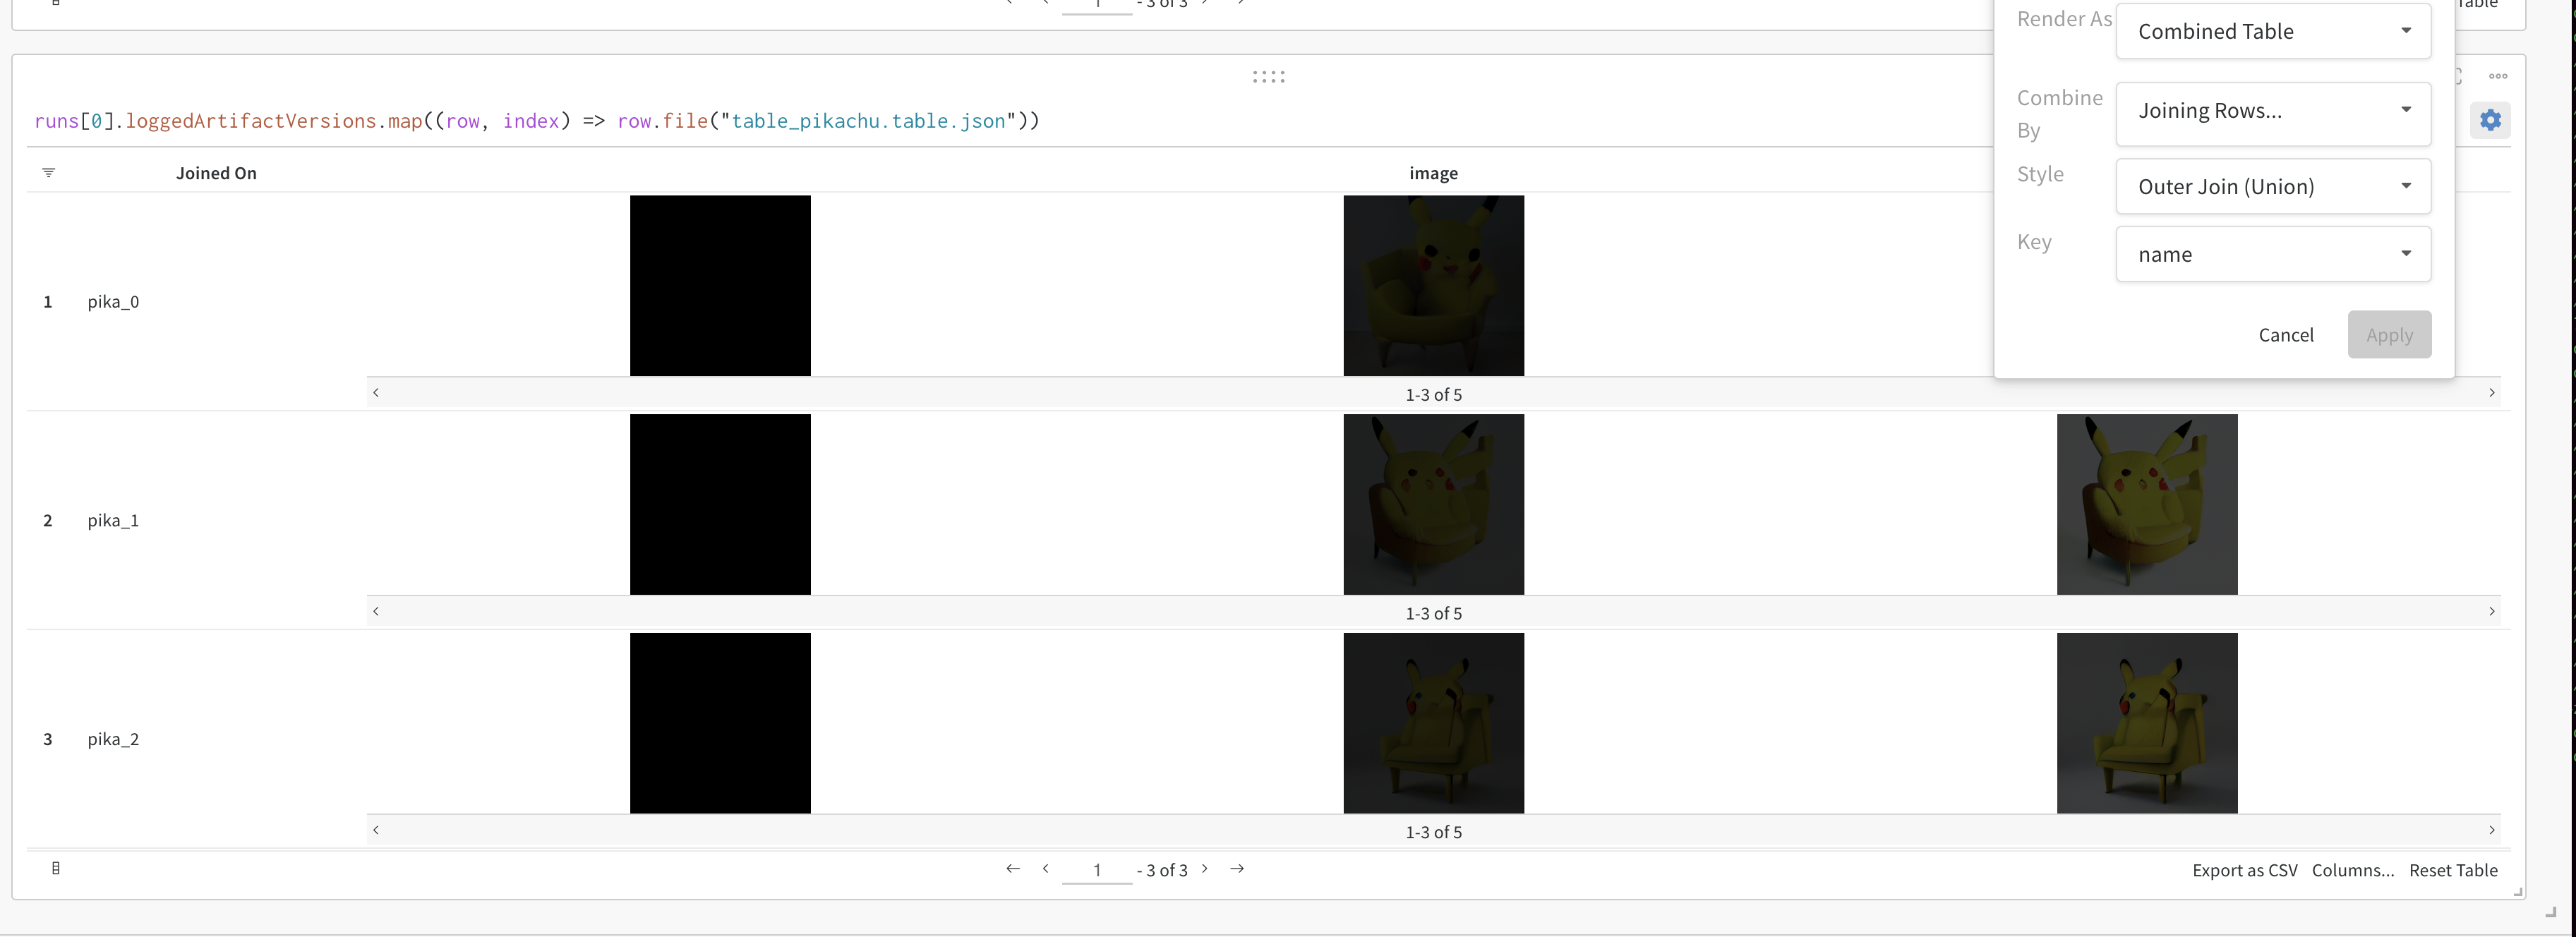

Finally, you can change how the column is displayed by clicking on the ... next to the column name `image` and changing to display 10 images at a time:
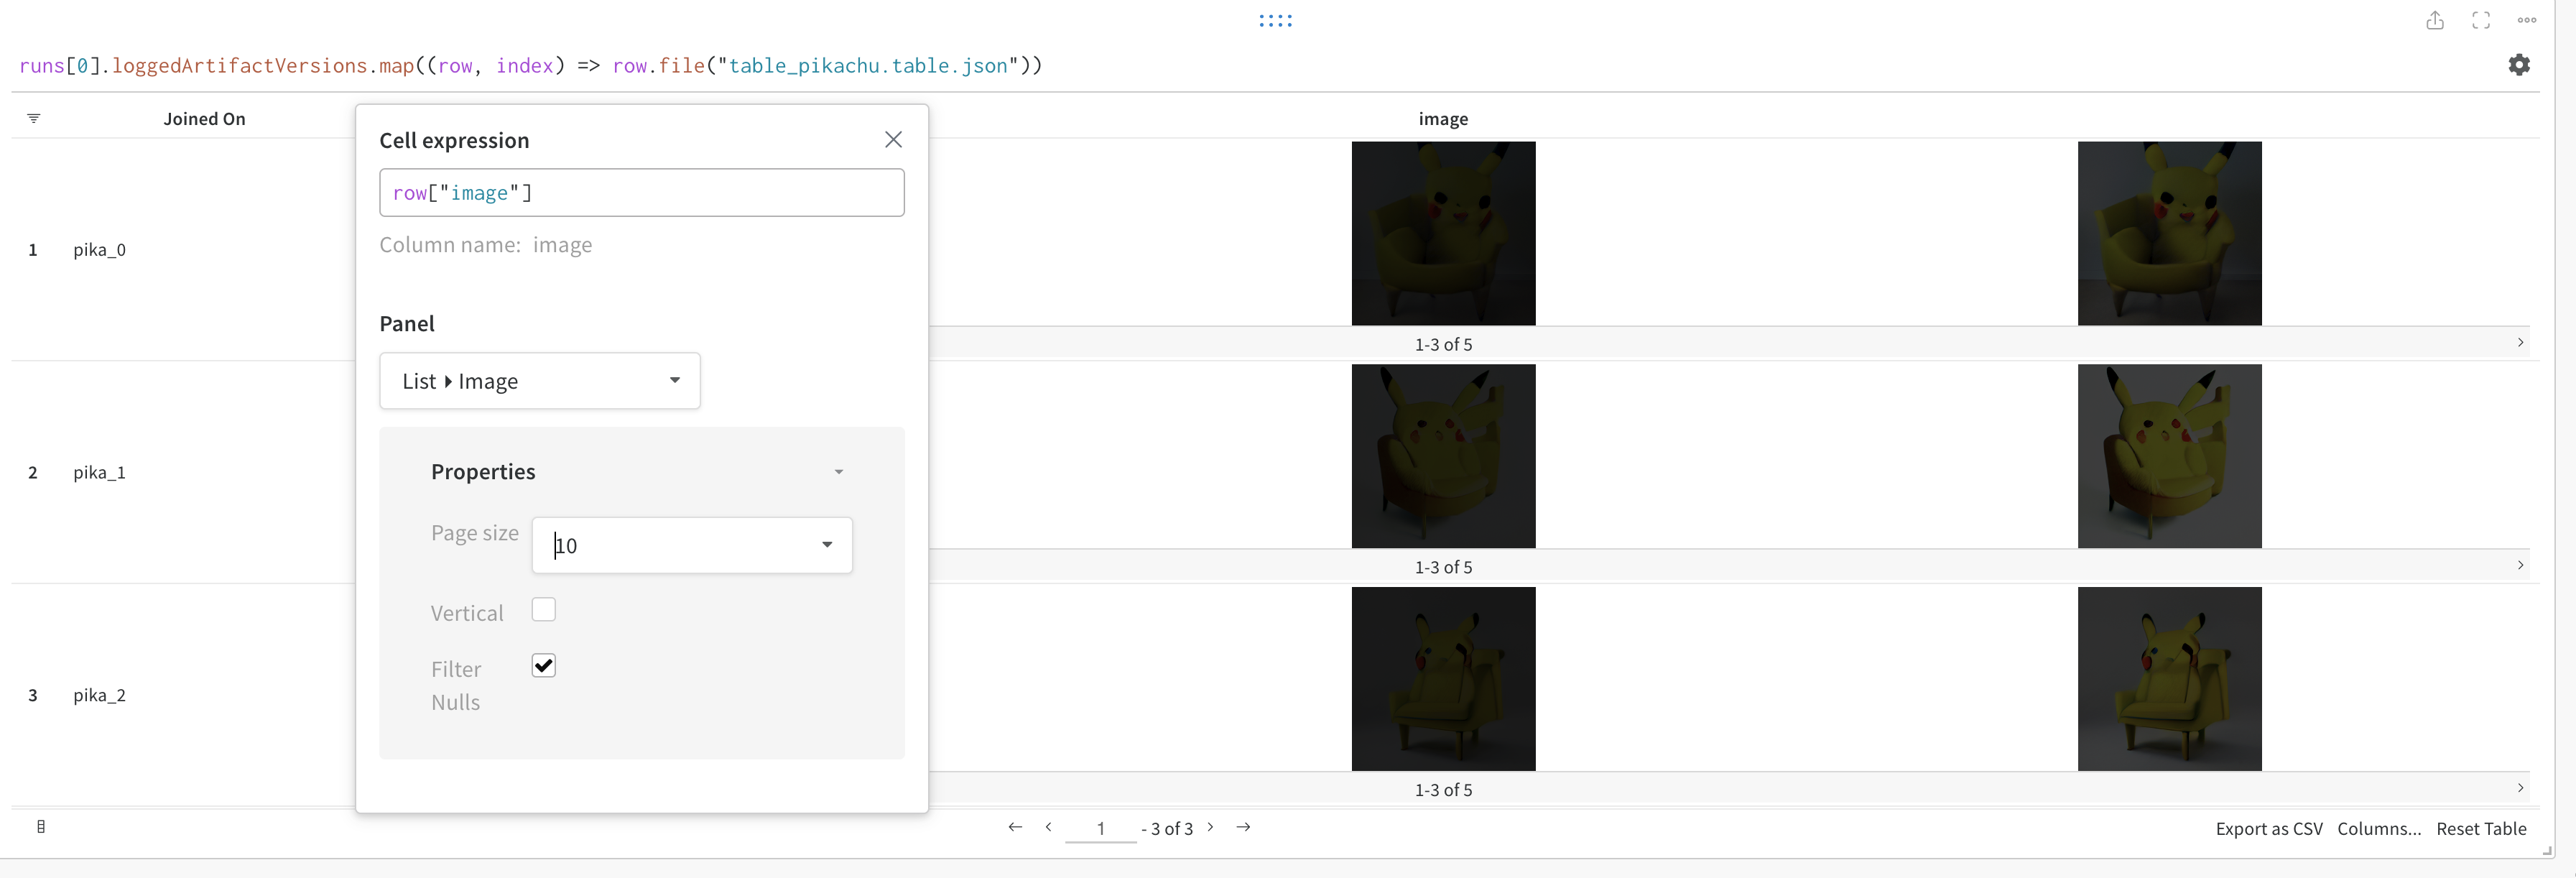

## Naming cols

Let's put the epoch number on the image column name: `f"image_{epoch}"`

In [24]:
from pathlib import Path

from PIL import Image
import numpy as np

In [25]:
def create_table(epoch):
    "Name the image column with the epoch explicitely"
    t = wandb.Table(columns=["name", f"image_{epoch}"])
    
    pikachus = sample_images(epoch)
    
    for i, pika in enumerate(pikachus):
        t.add_data(f"pika_{i}", wandb.Image(pika))
    
    return t

In [26]:
with wandb.init(project=PROJECT_NAME, job_type="images_col", config={"epochs":EPOCHS}):
    for epoch in range(EPOCHS):
        wandb.log({"table_pikachu_cols":create_table(epoch)})

On the run workspace you will need to create a weave panel and configure it to `OuterJoin`

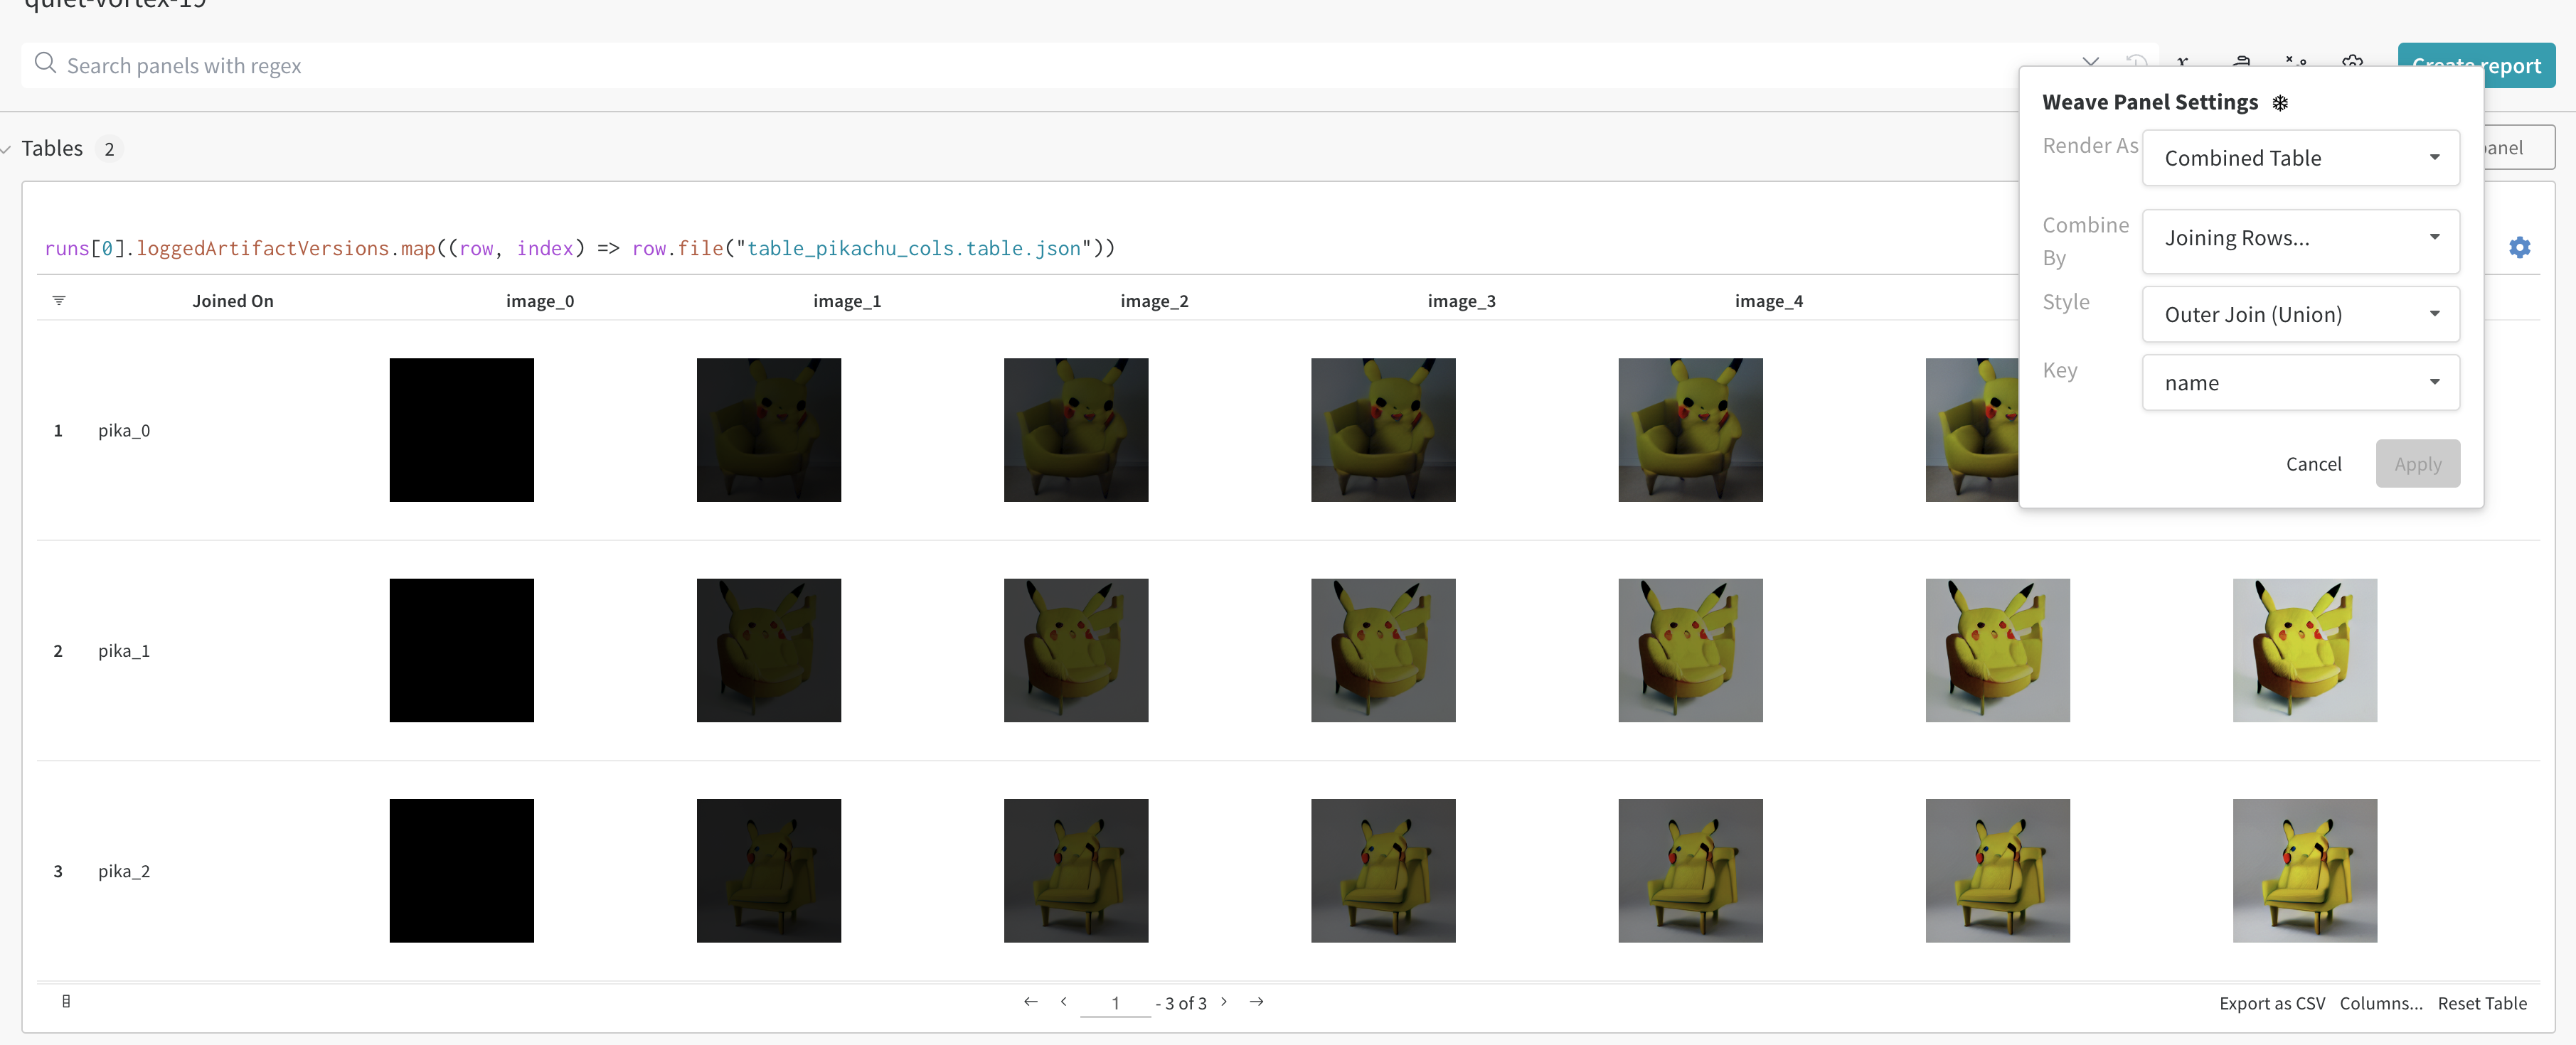